In [1]:
# Code to plot SSTs/SST anomalies for the ENSO region
# Author: Nathan Erickson
# Date: 1/11/2022
# Coded with Python 3.8.10

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime

from lib import sst_bias_ens_calculator, sst_change_ens_calculator

ERROR 1: PROJ: proj_create_from_database: Open of /opt/miniconda3/envs/prod/share/proj failed


In [3]:
# Set base directory, open data file

data_dir = '/chinook2/nathane1/Thesis/'
home_dir = '/home/nathane1/Thesis/'
os.chdir(data_dir)

In [4]:
# Establish this up top

# Problem children: CNRM-CM6-1, MIROC6
model_list = ["ACCESS-CM2", "ACCESS-ESM1-5", "AWI-CM-1-1-MR", "BCC-CSM2-MR", "CAMS-CSM1-0", "CanESM5", "CESM2", "CESM2-WACCM", "CMCC-CM2-SR5", 
              "CNRM-CM6-1", "CNRM-CM6-1-HR", "CNRM-ESM2-1", "EC-Earth3", "EC-Earth3-Veg", "FGOALS-f3-L", "GFDL-CM4", "GFDL-ESM4", 
              "GISS-E2-1-G", "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR", "MIROC6", "MIROC-ES2L",
              "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0", "NESM3", "NorESM2-LM", "NorESM2-MM", "TaiESM1"]
ens_size = range(24,len(model_list))

In [5]:
# Run the bias/change calculation; clear up existing composite file if necessary

file = 'composite_bias.nc'
#if os.path.isfile(os.path.join(data_dir + file)) == True:
#    os.remove(file)

#for model in ens_size:
#    model_run = sst_bias_ens_calculator(model,model_list)
#    print(f'Successfully added {model_run} to composite dataset!')

In [6]:
composite_bias = xr.open_dataset('/chinook2/nathane1/Thesis/composite_bias.nc')
#composite_change = xr.open_dataset('/chinook2/nathane1/Thesis/composite_change.nc')
#sst_change_ens_calculator(2,model_list)

In [7]:
variables = list(composite_bias)

da_list = [composite_bias[var].expand_dims('ensemble', axis=0).
                   assign_coords(ensemble=[var]).
                   rename('SST') for var in variables]

composite = xr.merge(da_list)

global_attrs = composite.attrs
composite.attrs = composite_bias.attrs

composite

<xarray.Dataset>
Dimensions:   (ensemble: 31, lat: 89, lon: 180)
Coordinates:
  * ensemble  (ensemble) <U18 'ACCESS-CM2-ts' ... 'TaiESM1-ts'
  * lat       (lat) float64 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon       (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Data variables:
    SST       (ensemble, lat, lon) float64 nan -32.36 -32.33 ... nan nan nan

In [8]:
obs_ssts = xr.open_dataset('/chinook2/nathane1/Thesis/sst.mnmean.nc')
land_mask = xr.open_dataset('/chinook2/nathane1/Thesis/CMIP6/MPI-ESM1-2-HR/sftlf_fx_MPI-ESM1-2-HR_historical_r1i1p1f1_gn.nc').interp_like(obs_ssts.lon).interp_like(obs_ssts.lat)
obs_ssts.sst

<xarray.DataArray 'sst' (time: 2012, lat: 89, lon: 180)>
[32232240 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-08-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [9]:
np.count_nonzero(np.isnan(obs_ssts.sst[0]))

5032

In [11]:
composite = composite.interpolate_na(dim='lon',method='nearest').where(land_mask['sftlf'] == 0).where(obs_ssts.sst[0] != np.nan)#.groupby('lat').mean('time')

Text(0.5, 1.0, 'Ensemble Averaged SST Biases over Contemporary Period (1854 - 2021)')

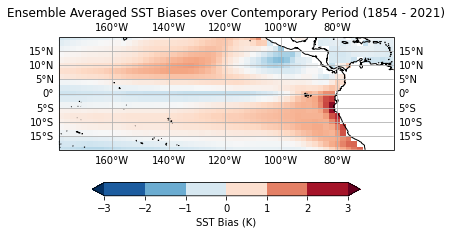

In [12]:
composite_plot = composite['SST'].mean('ensemble').plot(
    transform=ccrs.PlateCarree(),  # this is important!
    #col = "time",
    # usual xarray stuff
    subplot_kws={"projection": ccrs.PlateCarree()},
    cmap = 'RdBu_r', # Set a colormap
    norm = mpl.colors.Normalize(vmin = -3, vmax = 3), # Normalize the colors
    cbar_kwargs={"label": "SST Bias (K)","boundaries": list(np.arange(-3,4)), "orientation": "horizontal", "shrink": 0.8},
    robust=True,
)

composite_plot.axes.coastlines()
composite_plot.axes.gridlines(draw_labels=True)
composite_plot.axes.set_extent([-179,-60,20,-20], crs=ccrs.PlateCarree())
composite_plot.axes.set_title(f'Ensemble Averaged SST Biases over Contemporary Period (1854 - 2021)')

In [14]:
img_dir = '/home/nathane1/Thesis/images'
os.chdir(img_dir)

composite_fig = composite_plot.get_figure()
composite_fig.savefig(f'composite_sst_biases.jpg', bbox_inches = 'tight')

In [ ]:
composite_full = composite['SST'].mean('ensemble', skipna = False)#.where(obs_ssts.sst != np.nan).interpolate_na(dim = 'lon', method = 'nearest')

change_plot = composite_full.plot(
    transform=ccrs.PlateCarree(),  # this is important!
    #col = "time",
    # usual xarray stuff
    subplot_kws={"projection": ccrs.PlateCarree()},
    cmap = 'RdBu_r', # Set a colormap
    norm = mpl.colors.Normalize(vmin = 0, vmax = 5), # Normalize the colors
    cbar_kwargs={"label": "SST Change (K)","boundaries": list(np.arange(0,6)), "orientation": "horizontal", "shrink": 0.8},
    robust=True,
)

change_plot.axes.coastlines()
change_plot.axes.gridlines(draw_labels=True)
change_plot.axes.set_extent([-179,-60,20,-20], crs=ccrs.PlateCarree())
change_plot.axes.set_title(f'Ensemble Averaged SST Change over Cumulative Period (1850 - 2100)')

In [53]:
os.chdir(img_dir)

change_fig = change_plot.get_figure()
change_fig.savefig(f'composite_sst_change.jpg', bbox_inches = 'tight')

Text(0.5, 1.0, 'SST Biases for NorESM2-LM over Cumulative Period (1854 - 2021)')

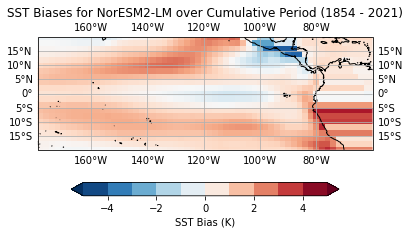

In [22]:
#period_djf_filled = period_djf_bias.interpolate_na(dim='lon',method='nearest')
period_plot = period_djf_bias.plot(
    transform=ccrs.PlateCarree(),  # this is important!
    #col = "time",
    # usual xarray stuff
    subplot_kws={"projection": ccrs.PlateCarree()},
    cmap = 'RdBu_r', # Set a colormap
    norm = mpl.colors.Normalize(vmin = -5, vmax = 5), # Normalize the colors
    cbar_kwargs={"label": "SST Bias (K)","boundaries": list(np.arange(-5,6)), "orientation": "horizontal", "shrink": 0.8},
    robust=True,
)

period_plot.axes.coastlines()
period_plot.axes.gridlines(draw_labels=True)
period_plot.axes.set_extent([-179,-60,20,-20], crs=ccrs.PlateCarree())
period_plot.axes.set_title(f'SST Biases for {model} over Cumulative Period (1854 - 2021)')

In [18]:
os.chdir(model_img_dir)

period_fig = period_plot.get_figure()
#period_fig.savefig(f'sst_biases_{model}_full_period.jpg', bbox_inches = 'tight')
#period_fig.savefig(f'sst_global_biases_{model}_full_period.jpg', bbox_inches = 'tight')

In [13]:
future_start = np.datetime64(np.datetime64('2050-02-16T12:00:00.000000000'))
future_data = model_avg.sel(time=slice('2050-02-16T12:00:00.000000000','2101-01-01T12:00:00.000000000'))
historical_data = model_avg.sel(time=slice('1850-01-01T12:00:00.000000000','1900-01-01T12:00:00.000000000'))

NameError: name 'model_avg' is not defined

In [20]:
future_avg = future_data.groupby("lat").mean("time")
historical_avg = historical_data.groupby("lat").mean("time")

In [21]:
sst_change = future_avg - historical_avg
sst_change = sst_change.where(land_mask['sftlf'] != land_mask['sftlf'].max().values)
#sst_change = sst_change.where(land_mask['sftlf'] <= 10)

Text(0.5, 1.0, 'SST Change for TaiESM1 over Cumulative Period (1854 - 2100)')

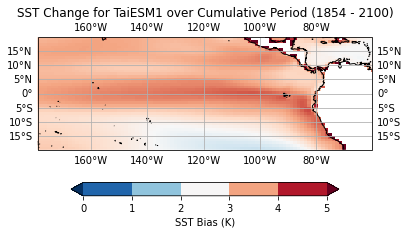

In [22]:
change_plot = sst_change.plot(
    transform=ccrs.PlateCarree(),  # this is important!
    #col = "time",
    # usual xarray stuff
    subplot_kws={"projection": ccrs.PlateCarree()},
    cmap = 'RdBu_r', # Set a colormap
    norm = mpl.colors.Normalize(vmin = 0, vmax = 5), # Normalize the colors
    cbar_kwargs={"label": "SST Change (K)","boundaries": list(np.arange(0,6)), "orientation": "horizontal", "shrink": 0.8},
    robust=True,
)

change_plot.axes.coastlines()
change_plot.axes.gridlines(draw_labels=True)
change_plot.axes.set_extent([-179,-60,20,-20], crs=ccrs.PlateCarree())
change_plot.axes.set_title(f'SST Change for {model} over Cumulative Period (1854 - 2100)')

In [23]:
os.chdir(model_img_dir)

#change_fig = change_plot.get_figure()
#change_fig.savefig(f'sst_change_{model}_full_period.jpg', bbox_inches = 'tight')